In [1]:
import numpy as np
import pickle
from PIL import Image
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt
from curvelops import FDCT2D
from curvelops.plot import curveshow
from skimage import io, color
import pandas as pd
from scipy.signal import cwt, ricker
import multiprocessing
import cv2
# Open the image using Pillow

# Convert the image to a numpy array
#image_array = np.array(image)

# Print the shape of the numpy array



# Load an image
#image = cv2.imread('./data/2Perfect.jpg', cv2.IMREAD_GRAYSCALE)
#image = Image.open('./data/2Perfect.jpg')
#image_array = np.array(image)
#print(image_array.shape)

#image_array = image_array.astype(float)
#image_array /= 255.0
# Convert the image to grayscale if it's not already
#if len(image_array.shape) == 3:
#    image_array = np.mean(image_array, axis=2)

# Define the wavelet function (Ricker wavelet, also known as the Mexican hat wavelet)





#widths = np.arange(1, 31)

#wavelet = lambda x,y:print([x,y]) 
#print(image_array.ravel().shape)
# Apply the Continuous Wavelet Transform (CWT)
#coefficients = cwt(image_array,wavelet, widths)
def fdct_lbp(path):
    image_array = cv2.imread(path)
    #image = Image.open(path)
    #image_array = np.array(image)
    
    
    image_array = image_array.astype(float)
    image_array /= 255.0
    logo = image_array
    C2D  = FDCT2D(image_array.shape[:-1], nbscales=4, nbangles_coarse=16, allcurvelets=False)
    #coefficients = C2D.struct(C2D @ image_array)
    # Parameters for LBP
    subband = []
    logo_r = C2D.struct(C2D @ image_array[..., 0])
    logo_g = C2D.struct(C2D @ image_array[..., 1])
    logo_b = C2D.struct(C2D @ image_array[..., 2])

    # Concatenate the curvelet coefficients for each wedge
    logo_c = [[] for _ in logo_r]
    for iscale, c_angles in enumerate(logo_r):
        logo_c[iscale] = []
        for iwedge, c_wedge in enumerate(c_angles):
            wedges = [
                c[iscale][iwedge][..., np.newaxis].real
                for c in [logo_r, logo_g, logo_b]
            ]
            out = np.concatenate(wedges, axis=-1)
            # Rescaling because the curvelet coefficients are stronger than
            # the original signal due to the FFT normalization
            out *= np.sqrt(logo_r[iscale][iwedge].size / logo[..., 0].size)

            # However, the above scaling may put the signal outside of the [0, 1]
            # interval required for RGB images. As such we will rescale - purely
            # for visualization purposes, values between 0 and 1.
            out = (out - out.min()) / (out.max() - out.min())
            logo_c[iscale].append(out)
            subband.append(out)
    # Apply LBP to each curvelet coefficient
    radius = 1
    n_points = 8 * radius

    # Initialize a list to store LBP patterns
    lbp_patterns = []

    for coef in subband:
        #print(coef.shape)
        #image = color.rgb2gray(coef)
        lbp = local_binary_pattern(coef[0], n_points, radius, method='uniform')
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-7)
        lbp_patterns.append(hist)
    aggregated_features = np.concatenate(lbp_patterns)
    return aggregated_features

In [2]:
df = pd.read_csv('./GroundTruth.csv')

segmented_path = '/home/rajdeep/projects/image_segmentation/data/segmented/'
columns = ['MEL','NV','BCC','AKIEC','DF','VASC']
class_metadata = {} 
class_col = []
data_col = []
for col in columns:
    imgs = df[df.loc[:,col]==1]['image']
    imgs = map(lambda x:segmented_path + x + '.jpg',imgs)
    category = col
    one_hot_encoded = df[df.loc[:,col]==1].loc[:,columns].values
    print(one_hot_encoded.shape)
    class_metadata[category] = one_hot_encoded[0] 
    with multiprocessing.Pool(processes=16) as pool:
        res = pool.map(fdct_lbp, imgs)
        data_col.append(res)
        class_col.append(one_hot_encoded)
        pool.close()
        pool.join()
    

(1113, 6)


/home/rajdeep/projects/en/lib/python3.10/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/home/rajdeep/projects/en/lib/python3.10/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/home/rajdeep/projects/en/lib/python3.10/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer d

(6705, 6)


/home/rajdeep/projects/en/lib/python3.10/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/home/rajdeep/projects/en/lib/python3.10/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/home/rajdeep/projects/en/lib/python3.10/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer d

(514, 6)


/home/rajdeep/projects/en/lib/python3.10/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/home/rajdeep/projects/en/lib/python3.10/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/home/rajdeep/projects/en/lib/python3.10/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer d

(327, 6)


/home/rajdeep/projects/en/lib/python3.10/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/home/rajdeep/projects/en/lib/python3.10/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/home/rajdeep/projects/en/lib/python3.10/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer d

(115, 6)


/home/rajdeep/projects/en/lib/python3.10/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/home/rajdeep/projects/en/lib/python3.10/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/home/rajdeep/projects/en/lib/python3.10/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer d

(142, 6)


/home/rajdeep/projects/en/lib/python3.10/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/home/rajdeep/projects/en/lib/python3.10/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
/home/rajdeep/projects/en/lib/python3.10/site-packages/skimage/feature/texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer d

In [3]:
import pickle
data_card = {}
data_card['class_metadata'] = class_metadata
data_card['features'] = np.concatenate(data_col)
data_card['labels'] = np.concatenate(class_col)
print(data_card['features'].shape)
print(data_card['labels'].shape)
# File path to save the pickled dictionary
file_path = "./fdct_lbp.pkl"

# Save the dictionary as a pickled file
with open(file_path, "wb") as file:
    pickle.dump(data_card, file)

print("Dictionary saved as a pickled file.")


# Load the pickled dictionary
with open(file_path, "rb") as file:
    loaded_dict = pickle.load(file)
    print("Loaded dictionary:", loaded_dict.keys())

(8916, 500)
(8916, 6)
Dictionary saved as a pickled file.
Loaded dictionary: dict_keys(['class_metadata', 'features', 'labels'])


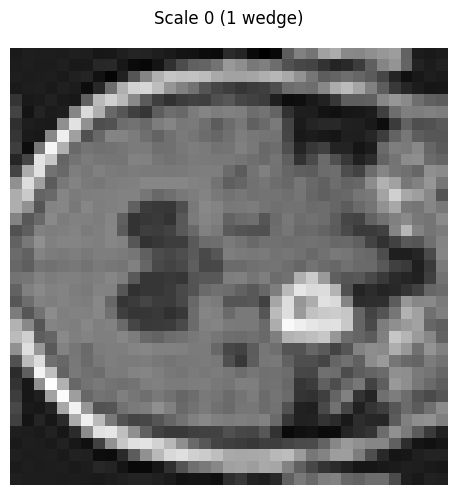

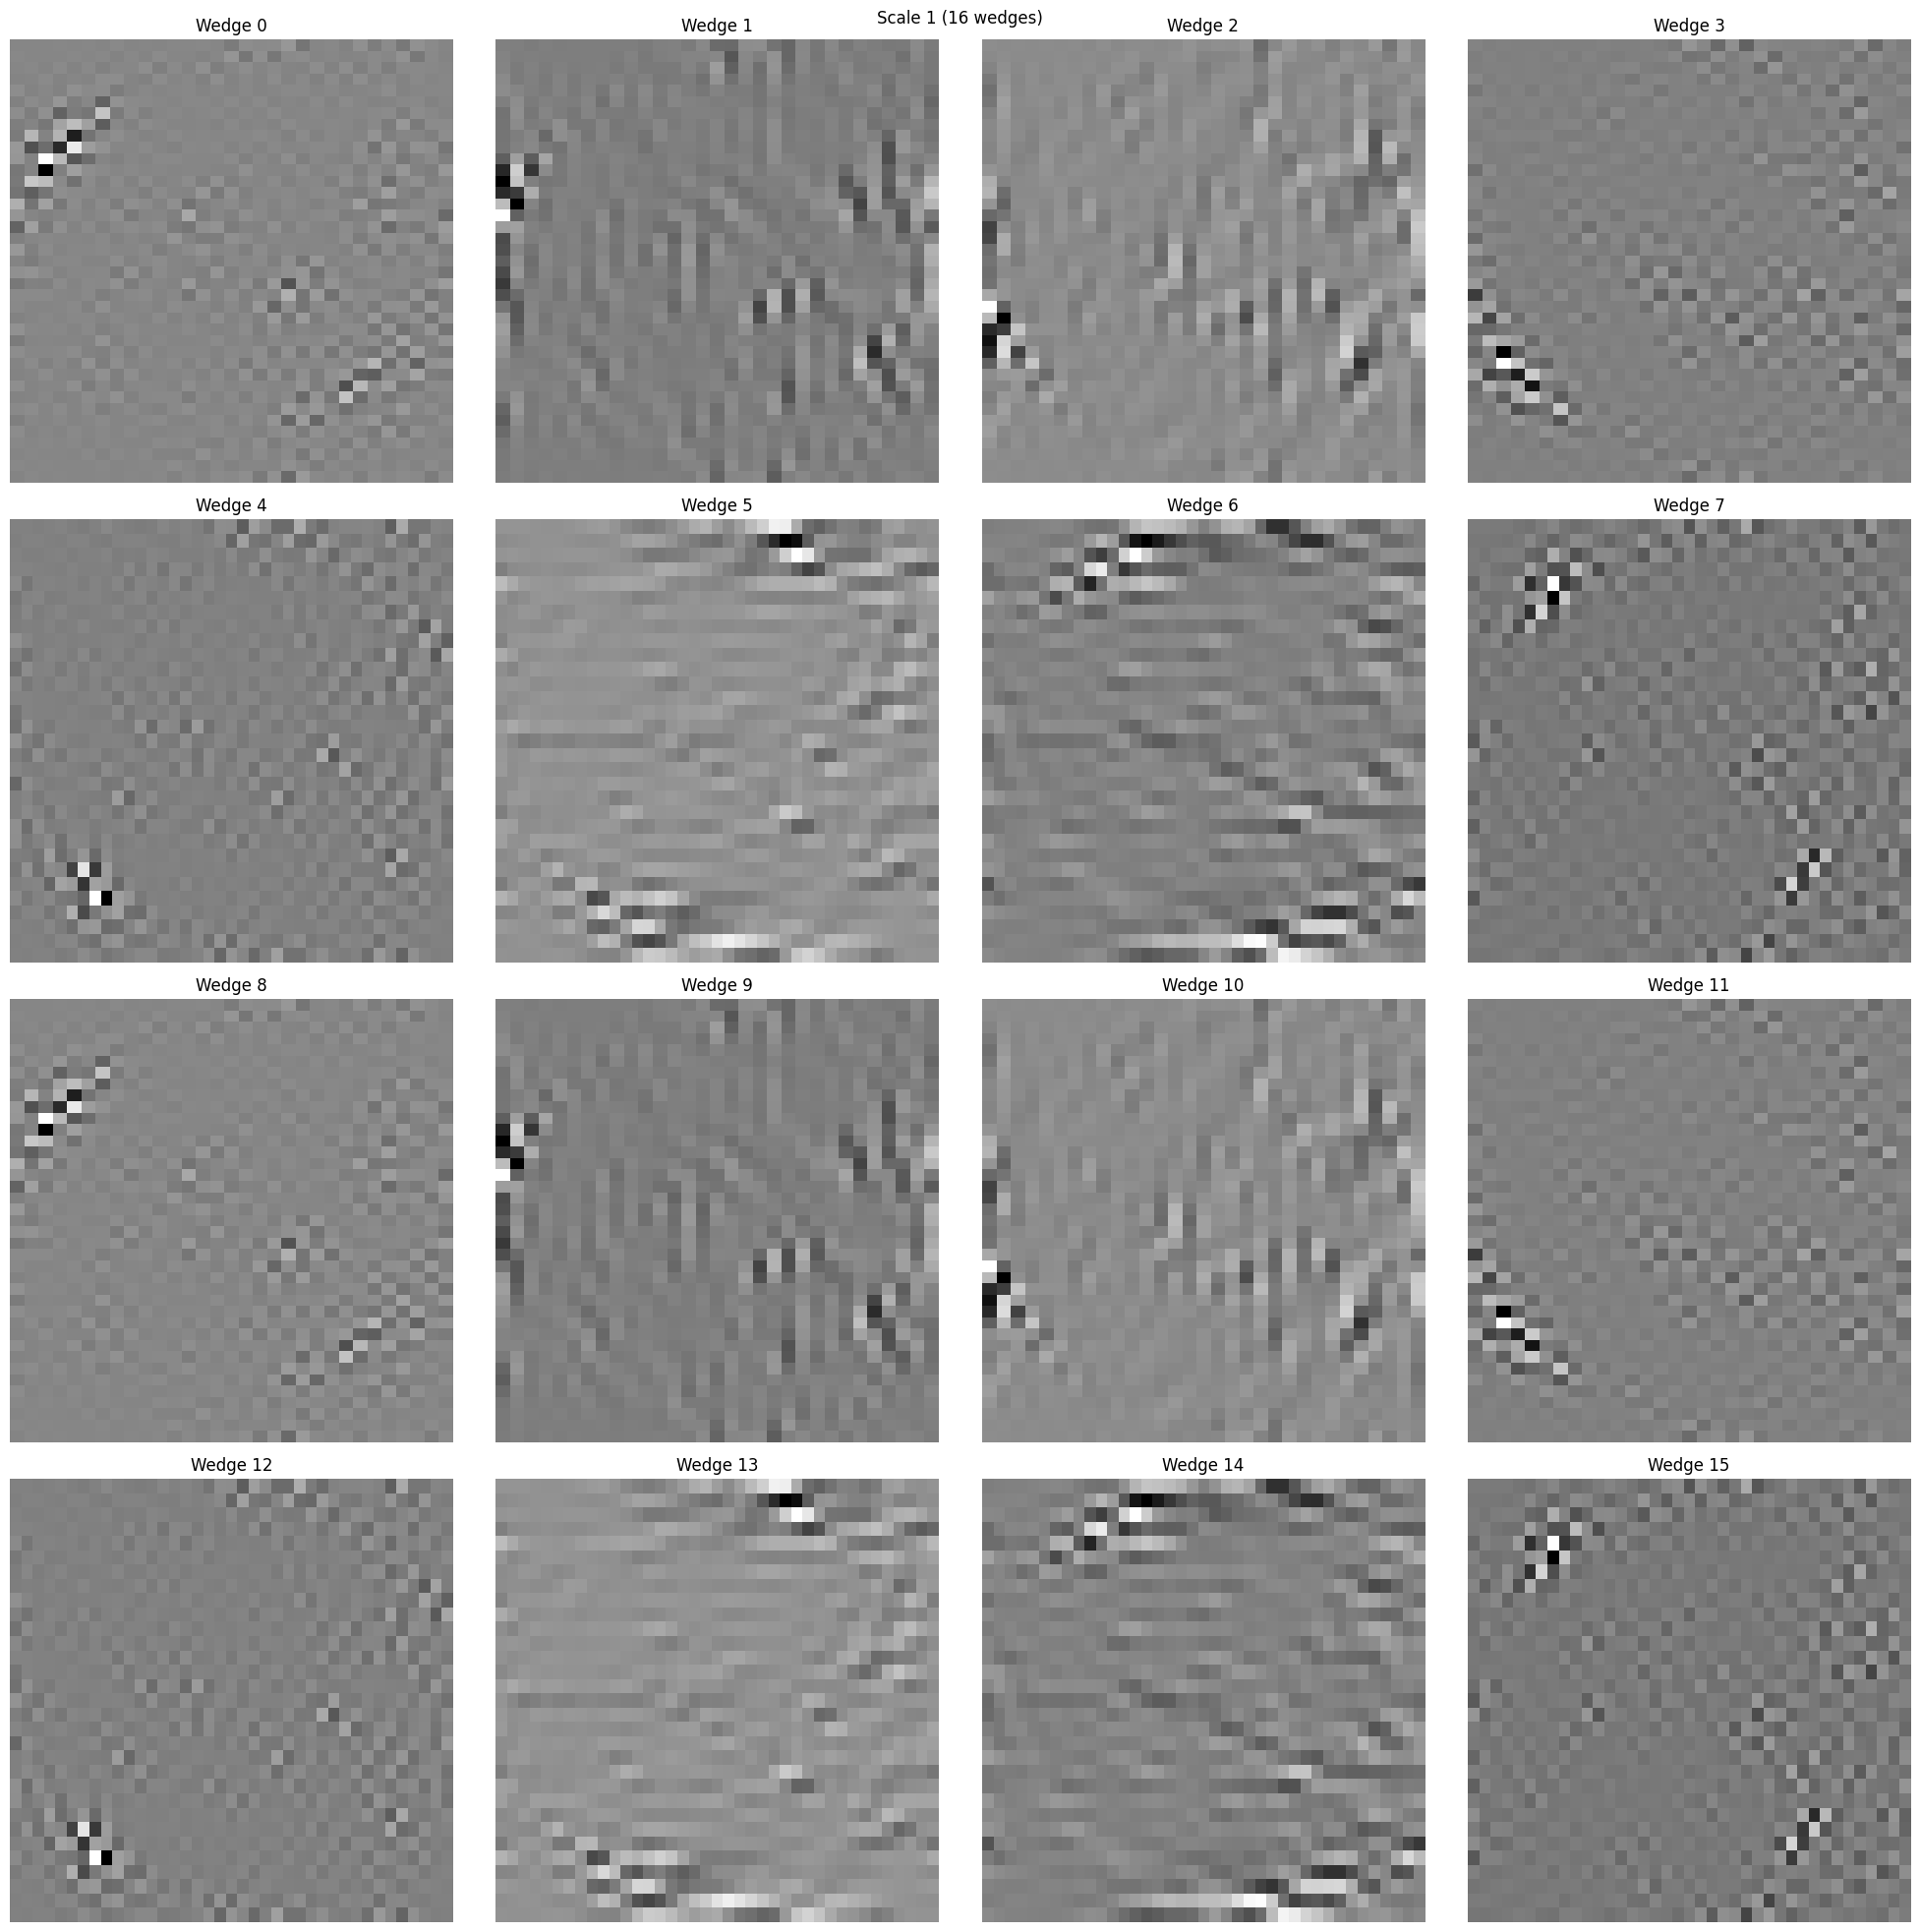

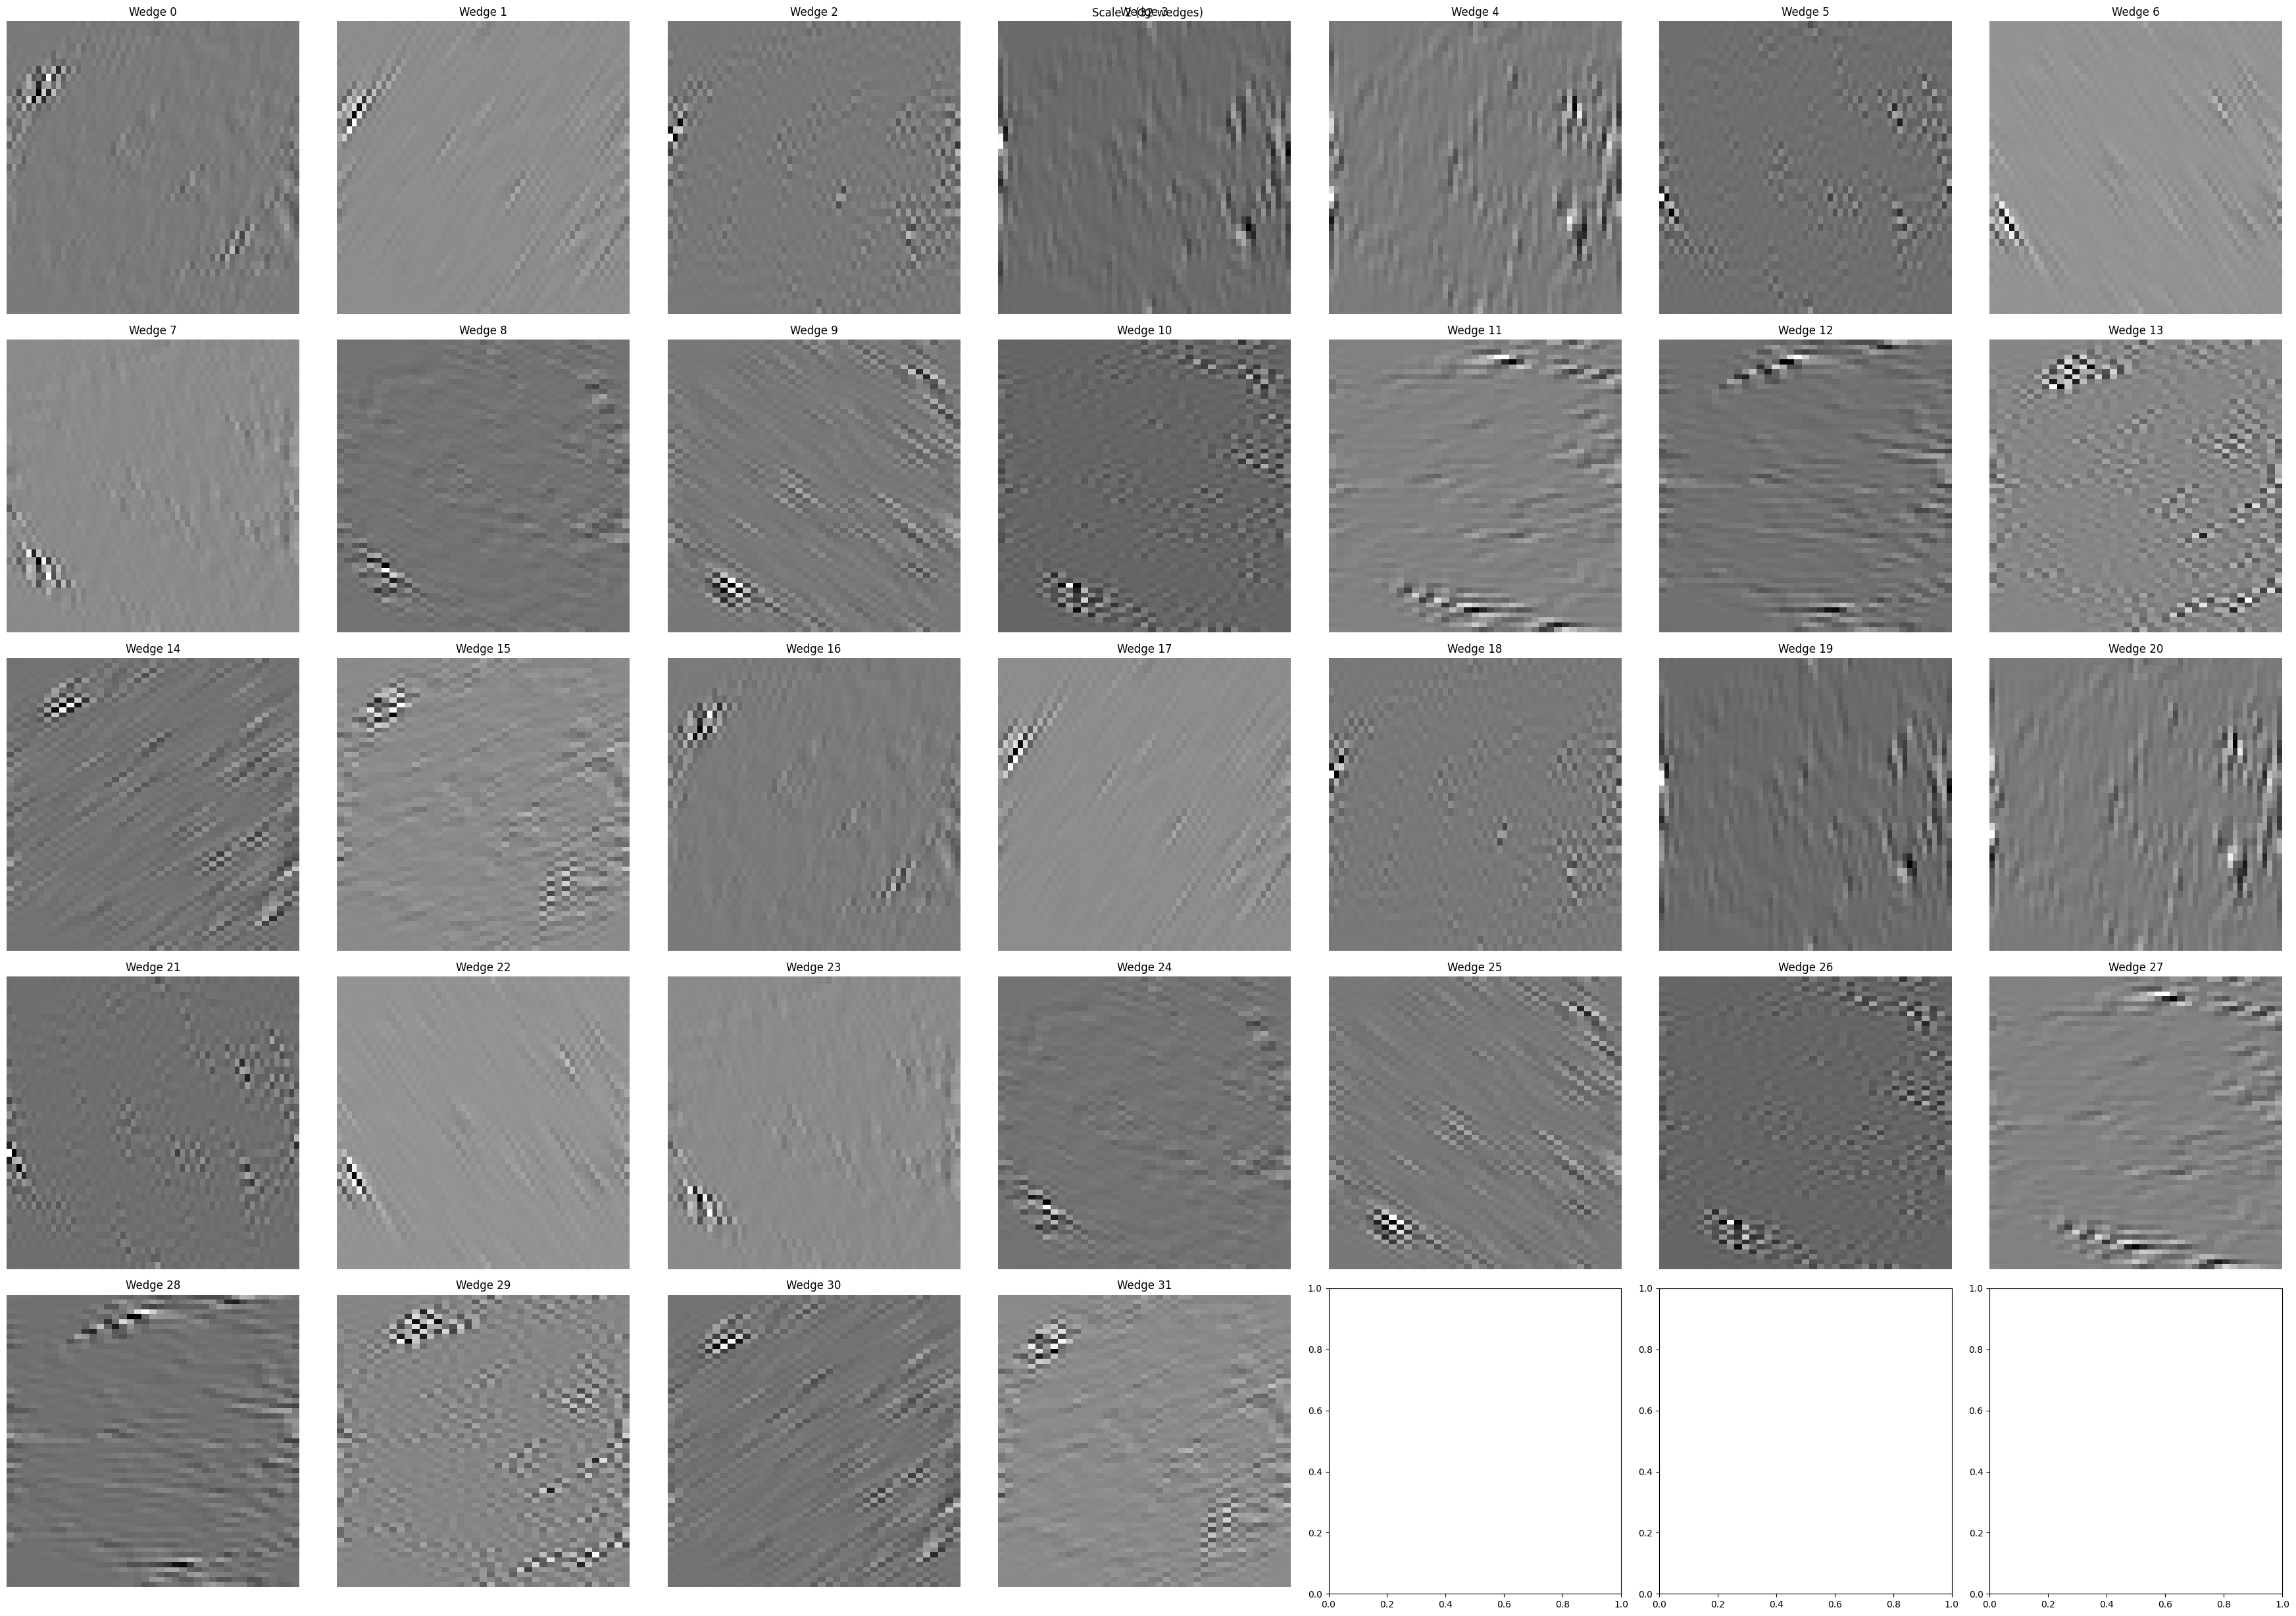

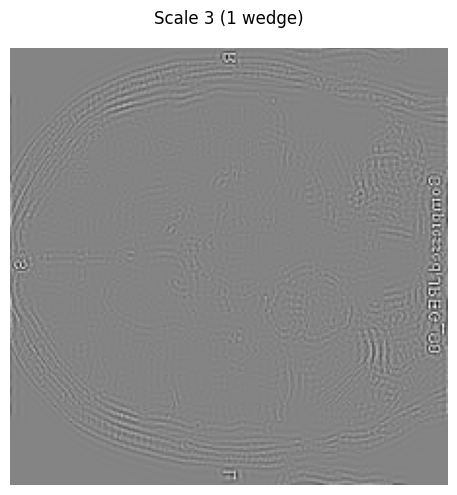

In [87]:
fig_axes = curveshow(logo_c, kwargs_imshow=dict(extent=[0, 1, 1, 0]))


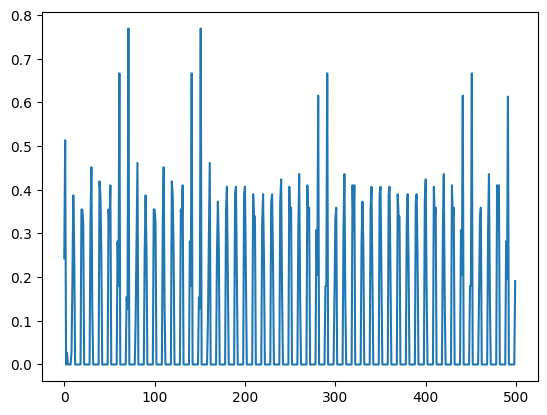

In [117]:
plt.plot(aggregated_features)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve

# Generate a sample signal
signal = np.sin(2 * np.pi * 5 * np.linspace(0, 1, 100))

# Define the scales and time vector
scales = np.linspace(1, 30, 20)
time = np.linspace(0, 1, 100)
print(signal.shape)
# Define the Morlet wavelet function
def morlet(t, w0=6):
    return np.cos(w0 * t) * np.exp(-t**2 / 2)

# Calculate CWT using convolution
cwt_matrix = np.zeros((len(scales), len(signal)))
for i, scale in enumerate(scales):
    # Scaled and shifted wavelet
    wavelet = morlet(scale * time)
    
    # Convolve wavelet with the signal
    cwt_matrix[i, :] = convolve(signal, wavelet, mode='same')

# Plot CWT coefficients
plt.imshow(np.abs(cwt_matrix), extent=[0, 1, scales[-1], scales[0]],
           cmap='jet', aspect='auto', origin='lower')
plt.colorbar(label='Wavelet Coefficient')
plt.title('Continuous Wavelet Transform')
plt.xlabel('Time')
plt.ylabel('Scale')
plt.show()

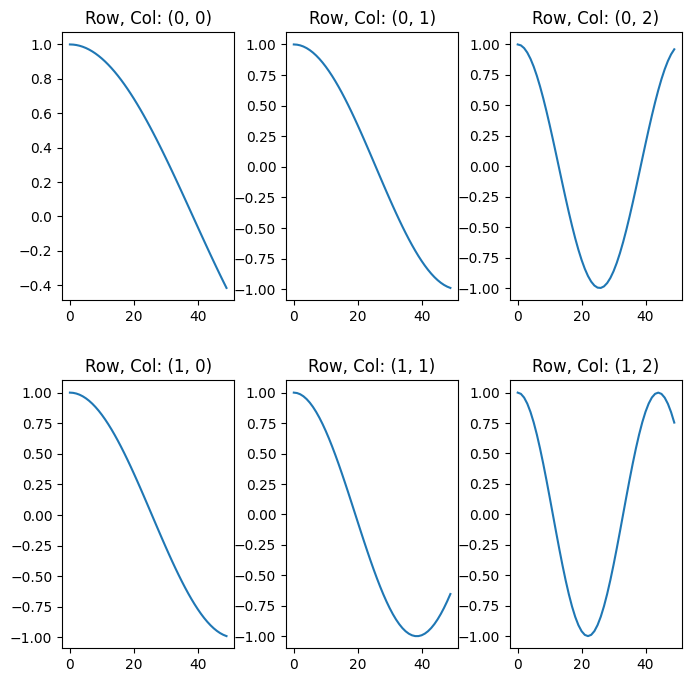

In [2]:

from curvelops.plot import create_axes_grid
rows, cols = 2, 3
fig, axs = create_axes_grid(
    rows,
    cols,
    kwargs_figure=dict(figsize=(8, 8)),
    kwargs_gridspec=dict(wspace=0.3, hspace=0.3),
)
for irow in range(rows):
    for icol in range(cols):
        axs[irow][icol].plot(np.cos((2 + irow + icol**2) * np.linspace(0, 1)))
        axs[irow][icol].set(title=f"Row, Col: ({irow}, {icol})")